In [126]:
!pip install transformers

In [127]:
!pip install torch===1.7.1 torchvision===0.8.2 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [128]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Importing and preprocessing datasets

In [129]:
pos_df = pd.read_csv('positive.csv', delimiter=';', header=None)
neg_df = pd.read_csv('negative.csv', delimiter=';', header=None)

In [130]:
pos_df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1
5,408906761769598976,1386325943,JustinB94262583,ну любишь или нет? — Я не знаю кто ты бля:D ht...,1,0,0,0,40,6,16,0
6,408906762436481024,1386325943,twinkleAYO,"RT @SpoonLamer: Ох,900 :D ну это конечно же @t...",1,0,1,0,5169,58,43,2
7,408906764114206720,1386325944,pycalyruhog,RT @veregijytaqo: У тебя есть ухажёр? Нет - мо...,1,0,2,0,393,112,153,0
8,408906764608749568,1386325944,grishintv,Поприветствуем моего нового читателя @Alexey17...,1,0,0,0,5872,1387,1431,12
9,408906765841870848,1386325944,alina_612,Теперь у меня есть частичка Сиднея :) #Sydney ...,1,0,0,0,263,5,36,0


In [131]:
df = pd.concat([pos_df, neg_df], ignore_index=True).sample(frac=1).reset_index(drop=True)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
0,411200208673198080,1386872744,Lidamagomedovna,"RT @SPB_citizen: В Сирии сейчас больше снега ,...",1,0,1,0,17645,403,324,12
1,410144087635816448,1386620945,DDikij1,@svobodailismert Хе-хе-хехе! А потом они будут...,1,0,0,0,6705,430,466,10
2,413666873717170177,1387460842,Yatrava,@almadiel1985 ну это же не по прааавилааам(((,-1,0,0,0,20403,106,163,2
3,409370939600953344,1386436612,StepashkaMimi,"Мы седели в троем @Alex_Krylova, @Nastya_Kicha...",1,0,0,0,216,34,38,0
4,419513785993265152,1388854855,Kate_choc_art,"я могла всегда поднять настроение сама себе, н...",-1,0,0,0,5242,62,51,0
5,409098287950860289,1386371607,iwokehor,Сидим возле стеллы. Хорошо :) Только берег под...,1,0,0,0,48,48,46,0
6,424166946637348864,1389964255,lizmatkowskayay,"вот все тебе не нравится!!! не хочешь идти,не ...",-1,0,0,0,145,13,18,0
7,410850206352035841,1386789297,Orioncannon93,Никакого Конеца Света в 2012 не будет! Лучше д...,1,0,0,0,27,0,3,0
8,411113700972838913,1386852119,DianaLluvia,"Как всегда я делаю че то не так, зря я отказал...",-1,0,0,0,6883,143,364,0
9,423855083189972992,1389889901,KisslizLove,"Наступать на одни и те же граблии...Да,это я у...",-1,0,0,0,4,0,1,0


In [132]:
df = df[df.columns[3:5]]
df.columns = [0,1]
df.head(10)

,0,1
0,"RT @SPB_citizen: В Сирии сейчас больше снега ,...",1
1,@svobodailismert Хе-хе-хехе! А потом они будут...,1
2,@almadiel1985 ну это же не по прааавилааам(((,-1
3,"Мы седели в троем @Alex_Krylova, @Nastya_Kicha...",1
4,"я могла всегда поднять настроение сама себе, н...",-1
5,Сидим возле стеллы. Хорошо :) Только берег под...,1
6,"вот все тебе не нравится!!! не хочешь идти,не ...",-1
7,Никакого Конеца Света в 2012 не будет! Лучше д...,1
8,"Как всегда я делаю че то не так, зря я отказал...",-1
9,"Наступать на одни и те же граблии...Да,это я у...",-1


In [133]:
df.shape

(226834, 2)

In [134]:
import re

def preprocess1(text):
        """Minimal text preprocessing
        """
        text = re.sub("^\s+|([A-Za-z])+|(@[A-Za-z0-9\_\-]+)|\n|\r|\s+$", ' ', text)
        return text.strip()


def preprocess2(num):
    if num == -1:
        return 0
    else:
        return num

In [135]:
df[0] = df.apply(lambda x: preprocess1(x[0]), axis=1)
df[1] = df.apply(lambda y: preprocess2(y[1]), axis=1)

In [136]:
df.head(10)

,0,1
0,": В Сирии сейчас больше снега , чем в Питере :))",1
1,Хе-хе-хехе! А потом они будут блеять перед ка...,1
2,ну это же не по прааавилааам(((,0
3,"Мы седели в троем , и я:) а тут пришли еще ...",1
4,"я могла всегда поднять настроение сама себе, н...",0
5,Сидим возле стеллы. Хорошо :) Только берег под...,1
6,"вот все тебе не нравится!!! не хочешь идти,не ...",0
7,Никакого Конеца Света в 2012 не будет! Лучше д...,1
8,"Как всегда я делаю че то не так, зря я отказал...",0
9,"Наступать на одни и те же граблии...Да,это я у...",0


In [137]:
df[1].value_counts()

1    114911
0    111923
Name: 1, dtype: int64

In [138]:
df = df[:2000]
df[1].value_counts()

0    1022
1     978
Name: 1, dtype: int64

In [139]:
df

,0,1
0,": В Сирии сейчас больше снега , чем в Питере :))",1
1,Хе-хе-хехе! А потом они будут блеять перед ка...,1
2,ну это же не по прааавилааам(((,0
3,"Мы седели в троем , и я:) а тут пришли еще ...",1
4,"я могла всегда поднять настроение сама себе, н...",0
...,...,...
1995,"Так устала сегодня , ужас ( Вот что значит, ко...",0
1996,"жесть, во сколько бы я не легла встаю около 11...",0
1997,"бля, я только рассказывал: там целых шесть тв...",1
1998,Маман не дает по телеку сверхов посмотреть....:(,0


# Loading model

In [140]:
model_name = "DeepPavlov/rubert-base-cased-conversational"

tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModel.from_pretrained(model_name)

# Preparing the Dataset

In [141]:
tokenized = df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [142]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [143]:
np.array(padded).shape

(2000, 88)

In [144]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 88)

## Train

In [145]:
input_ids = torch.tensor(padded).to(torch.int64)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [146]:
last_hidden_states

BaseModelOutputWithPoolingAndCrossAttentions([('last_hidden_state',
                                               tensor([[[-0.7776,  0.3477, -1.3833,  ...,  0.0406,  0.8057, -0.2731],
                                                        [-0.2460,  0.3605, -0.2855,  ...,  0.5049,  0.3040,  0.1113],
                                                        [ 0.4525,  0.2480,  0.0515,  ...,  0.9382,  0.2351,  0.9238],
                                                        ...,
                                                        [ 0.0600,  0.5781, -0.5176,  ...,  0.5192,  0.0973,  0.5347],
                                                        [ 0.5297,  0.6325, -0.3973,  ...,  0.2517,  0.3921,  0.6416],
                                                        [ 0.0108,  0.7864, -0.1998,  ..., -0.0957, -0.0854,  0.8079]],
                                               
                                                       [[ 0.3562, -0.0753, -0.6140,  ...,  0.3549,  0.5990, -0.819

In [147]:
features = last_hidden_states[0][:,0,:].numpy()  
len(features[0])

768

In [148]:
labels = df[1]

# Model #2: Train

In [149]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [150]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [151]:
lr_clf.score(test_features, test_labels)

0.952

In [152]:
pred = lr_clf.predict(test_features)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr_clf.score(test_features, test_labels)))

Accuracy of logistic regression classifier on test set: 0.95


In [153]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_labels, pred)
print(confusion_matrix)

[[226  13]
 [ 11 250]]


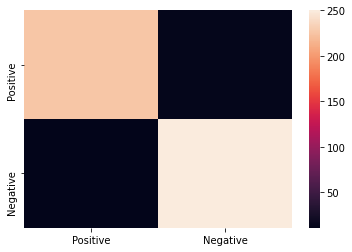

In [154]:
df = pd.DataFrame(confusion_matrix, index = ["Positive", "Negative"], columns = ["Positive", "Negative"])
sns.heatmap(df)

# Pipeline

In [162]:
@torch.no_grad()
def predict(text):
    text = preprocess1(text)
    tokenized = tokenizer.encode(text, add_special_tokens=True)
    input = torch.tensor([tokenized]).to(torch.int64)

    
    last_hidden_states = model(input)

    features = last_hidden_states[0][:,0,:].numpy()

    pred = lr_clf.predict(features)
    if pred[0] == 1:
        print("Positive")
    else:
        print("Negative")

In [163]:
predict("У меня получилось обучить модель!")

Positive


In [168]:
predict("Она работает очень быстро!")

Positive


In [165]:
predict("Жалко, что я сразу не нашел ошибку")

Negative


In [166]:
predict("Я люблю трансформеры")

Positive
